# Analysis of global happiness in 2019


### 1. What is important for being happy? 
### 2. How is happiness distributed in the world?
### 3. How well is the happiness-score predictable by its features?

#### Import, loading and preprocessing Data

In [1]:
# import of needed modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
#import plotly.io as pio
#pio.renderers.default = "png"
import scipy
from scipy import stats
import warnings
import warnings
warnings.filterwarnings('ignore')

# import of dataset
happy = pd.read_csv("files/2019.csv")

#rename the columns
happy.rename(columns={"Overall rank": "HappyRk", "Score" : "HappySc", "Country or region" : "Country", 
                       "GDP per capita": "GDP_per_capita", "Healthy life expectancy" : "LifeExp",
                       "Social support": "Family", "Freedom to make life choices": "Freedom",
                       "Perceptions of corruption" : "GovTrust",}, inplace=True)

# adding a column for "Region" from another dataset for regional exploration
df_reg = pd.read_csv("files/df_region.csv")
happy = pd.merge(happy, df_reg, on="Country", how = "left")

# Sorting Dataset and dropping not needed column "Unnamed:0"
happy = happy[['Country', 'ISO_code', 'Region', 'HappyRk', 'HappySc', 'GDP_per_capita', 'Family', 'LifeExp',
      'Freedom', 'Generosity', 'GovTrust']]

# happy.info() shows: No missing values


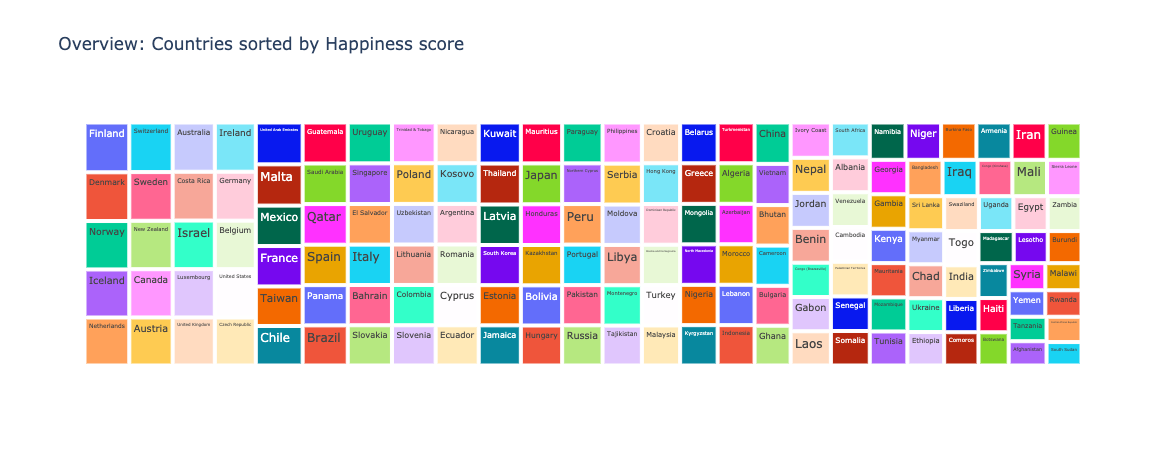

In [2]:
# A coloured overwiew which is more comfortable than a simple list. Sorted by Ranking (Columns left to right). 
# It's interactive, so you can see the single Happiness-Score of a country
fig = px.treemap(happy, path=["Country"], values='HappySc', title="Overview: Countries sorted by Happiness score")
fig.show() # interactive plot 
# fig.show("png") # can also show a picture of the plot for GitHub, but the size is too small, so I decided to show it as a picture in GitHub

![title](img/sorted_countries.png)

### The question, which nation has the happiest people is examined and rated by the global happiness-index since 2012.
##### The life evaluations from the Gallup World Poll provide the basis for the annual happiness rankings. The scores and rankings from 1 (poor) to 10 (best) refer to the same levels of the Cantril-Ladder.

### The Cantril-Ladder
![title](img/c.png)

#### The factors used to explain the score are
#####  - GDP per capita
#####  - Healthy Life Expectancy
#####  - Social support (Family)
#####  - Freedom to make life choices
#####  - Generosity
#####  - Corruption Perception (Trust in Government)


### After the preprocessing is done, we can see what the data looks like for the 156 countries

In [3]:
happy.head()

Country ISO_code          Region  HappyRk  HappySc  GDP_per_capita  \
0      Finland      FIN  Western Europe        1    7.769           1.340   
1      Denmark      DNK  Western Europe        2    7.600           1.383   
2       Norway      NOR  Western Europe        3    7.554           1.488   
3      Iceland      ISL  Western Europe        4    7.494           1.380   
4  Netherlands      NLD  Western Europe        5    7.488           1.396   

   Family  LifeExp  Freedom  Generosity  GovTrust  
0   1.587    0.986    0.596       0.153     0.393  
1   1.573    0.996    0.592       0.252     0.410  
2   1.582    1.028    0.603       0.271     0.341  
3   1.624    1.026    0.591       0.354     0.118  
4   1.522    0.999    0.557       0.322     0.298

In [4]:
# Using the "describe"-function to get an overview of the measurement data and their scaling
happy.describe()
# Checked the min-values with 0. There is only one per column and it has no influence on the investigation. 
# And could also be correct like in RgCode.

HappyRk     HappySc  GDP_per_capita      Family     LifeExp  \
count  156.000000  156.000000      156.000000  156.000000  156.000000   
mean    78.500000    5.407096        0.905147    1.208814    0.725244   
std     45.177428    1.113120        0.398389    0.299191    0.242124   
min      1.000000    2.853000        0.000000    0.000000    0.000000   
25%     39.750000    4.544500        0.602750    1.055750    0.547750   
50%     78.500000    5.379500        0.960000    1.271500    0.789000   
75%    117.250000    6.184500        1.232500    1.452500    0.881750   
max    156.000000    7.769000        1.684000    1.624000    1.141000   

          Freedom  Generosity    GovTrust  
count  156.000000  156.000000  156.000000  
mean     0.392571    0.184846    0.110603  
std      0.143289    0.095254    0.094538  
min      0.000000    0.000000    0.000000  
25%      0.308000    0.108750    0.047000  
50%      0.417000    0.177500    0.085500  
75%      0.507250    0.248250    0.141250  
max      0.631000    0.566000    0.453000

# 1. What is important for being happy? 

#### How are the individual features correlated with the happiness-score?
##### To explore this more exactly, we use three different correlation-markers (Heatmap, Linear regression (OLS) and Pearson-Correlation)
#### First the Correlation-Heatmap

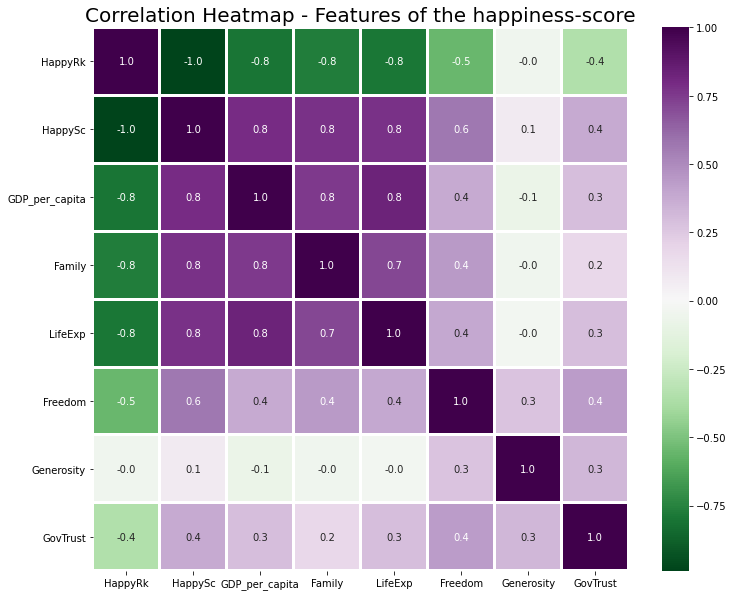

In [5]:
plt.figure(figsize=(12,10)) # Creating size of plot (height, width)
plt.title("Correlation Heatmap - Features of the happiness-score",fontsize=20) #adding title and its fontsize

# creating colored heatmap (cmap), annot = "True" puts the values in, fmt formats this value 
# and the linewidhts define the distance of the coloured clusters
sns.heatmap(data=happy.corr(),cmap="PRGn_r",annot=True, fmt='.1f', linewidths=2)

plt.show()

#### GDP-per capita, Family and Health-Life-Expectancy are strongly correlated with the happiness-score. 
#### Freedom and Perception of Corruption are not so strongly correlated and Generosity seems to have nearly no impact

#### Let's check if a linear regression (OLS) confirms this (result = R-Squared).

In [6]:
import statsmodels.api as sms #import module

a = list(happy.columns.values) # Creating the list with the features 
del a[0:4] # dropping not needed features out of the list

# Creating a function for my runthrough
def rsq(c):
    for i in a: # every single feature from "a" per loop
        X = happy[[i]] # The feature in this loop
        X = sms.add_constant(X) # fits also the intercept
        y = happy.HappySc # my dependent feature
        model = sms.OLS(y, X) #define the model, here "OLS"
        results = model.fit() # a variable for the result
        print(i + ": " + str(results.rsquared.round(2))) # and the printing function to show the R-Squared

In [7]:
rsq(a)

HappySc: 1.0
GDP_per_capita: 0.63
Family: 0.6
LifeExp: 0.61
Freedom: 0.32
Generosity: 0.01
GovTrust: 0.15


#### Here also the GDP-per-capita, Family and Life Expectancy have the strongest correlation with the happiness-score. 
### The following illustration shows the significant correlation between GDP per capita and the happiness-score.

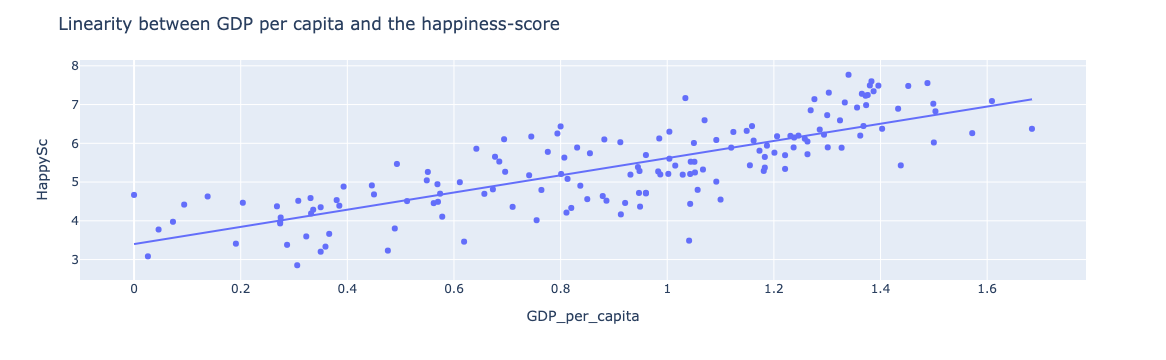

In [8]:
# Interactive plot with every single country and its values for GDP per capita and the Happiness-Score
# Also predicted values from OLS on every point of the line
fig = px.scatter(happy, x="GDP_per_capita", # selected features
                 y="HappySc",
                 hover_name="Country", # show Countryname
                trendline= "ols") # show Ordinary least squares line with predicted value

# Defining height and title
fig.update_layout(
    height=300,
    title_text='Linearity between GDP per capita and the happiness-score'
)
iplot(fig) # interactive plot for notebook
# fig.show("png") can also show a picture of the plot for GitHub, but the size is too small, so I decided to show it as a picture in GitHub

![title](img/GDP_Happy.png)

### Finally we compute the Pearson correlation

In [9]:
# Calculating with scipy-stats-module for every single feature
gdp = scipy.stats.pearsonr(happy['HappySc'], happy['GDP_per_capita'])
fam = scipy.stats.pearsonr(happy['HappySc'], happy['Family'])
lif = scipy.stats.pearsonr(happy['HappySc'], happy['LifeExp'])
fre = scipy.stats.pearsonr(happy['HappySc'], happy['Freedom'])
gen = scipy.stats.pearsonr(happy['HappySc'], happy['Generosity'])
gov = scipy.stats.pearsonr(happy['HappySc'], happy['GovTrust'])

#Printing the results
print("THE RESULTS FOR PEARSON CORRELATION ARE:")
print('GDP-per-capita         =', round(gdp[0],2))#, '   pvalue = ', round(c1[1],4))
print('Family                 =', round(fam[0],2))#, '   pvalue = ', round(c2[1],4))
print('Health-Life expectancy =', round(lif[0],2))# '   pvalue = ', round(c3[1],4))
print('Freedom                =', round(fre[0],2))#, '   pvalue = ', round(c4[1],4))
print('Generosity             =', round(gen[0],2))#, '   pvalue = ', round(c5[1],4))
print('Trust in Government    =', round(gov[0],2))#, '   pvalue = ', round(c6[1],4))

THE RESULTS FOR PEARSON CORRELATION ARE:
GDP-per-capita         = 0.79
Family                 = 0.78
Health-Life expectancy = 0.78
Freedom                = 0.57
Generosity             = 0.08
Trust in Government    = 0.39


#### Same result. This confirms that GDP-per-capita, family and life expectancy have the strongest correlation. 
#### Generosity has almost no correlation in all three models.

#### To complete this chapter, let's take a look at another survey on happiness made by [IPSOS](https://www.ipsos.com/sites/default/files/ct/news/documents/2019-08/Happiness-Study-report-August-2019.pdf) in 2019. They asked for the sources of happiness in detail. The next graphic shows how important the individual features were wheighted by the participants in this alternative survey.

#### Ipsos Happiness survey 2019 - What is important?
![title](img/Ipsos03.png)

#### While health is number one and financial dependencies are ranked 2nd, 8th, 10th, 12th, 17th, and 18th (20% of traits), we see that the high correlation of our features from the data set is also confirmed in detail from another source.

## Conclusion:
## Happiness mainly depends on money, health and our nearest social environment

# 2. How is happiness distributed in the world? 

#### Since the World Happiness Index only takes countries into account, I added a column with "Regions" to the data set to check whether there are regional aspects.
### So thess are the regions I took:

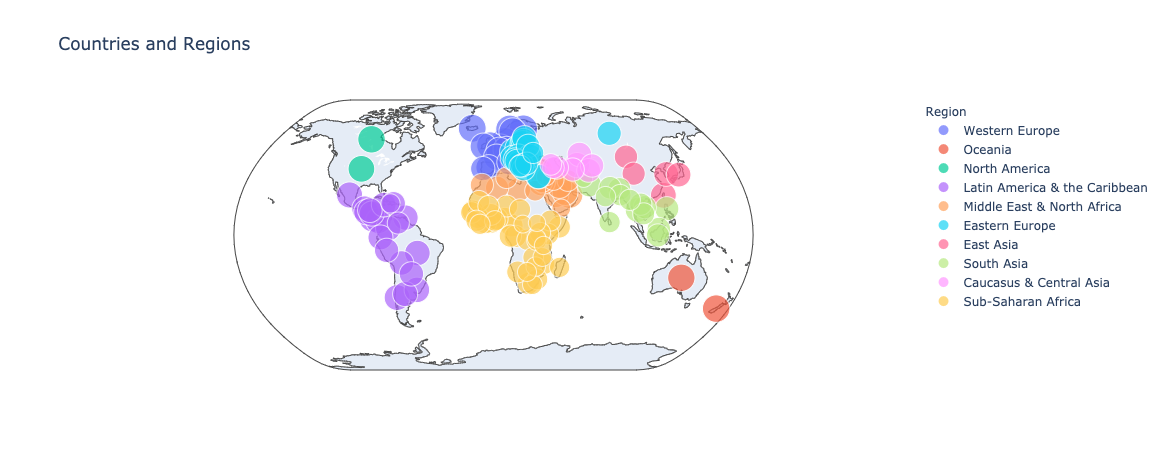

In [10]:
from plotly.offline import init_notebook_mode, iplot # importing iplot

# settings for my interactive geo-plot, countries = dots, regions = coloured
fig = px.scatter_geo(happy, 
                     locations='ISO_code',
                     color='Region',
                     size="HappySc", hover_name='Country', 
                     projection="natural earth", 
                     title='Countries and Regions',
                    )
iplot(fig) # interactive plot for notebook
# fig.show("png") can also show a picture of the plot for GitHub, but the size is too small, so I decided to show it as a picture in GitHub

![title](img/Regionmap.png)

### Does happiness only depend on the situation in each individual country or is there also a significant difference between the regions?
#### The 10 happiest and 10 most unhappy countries in the world are:

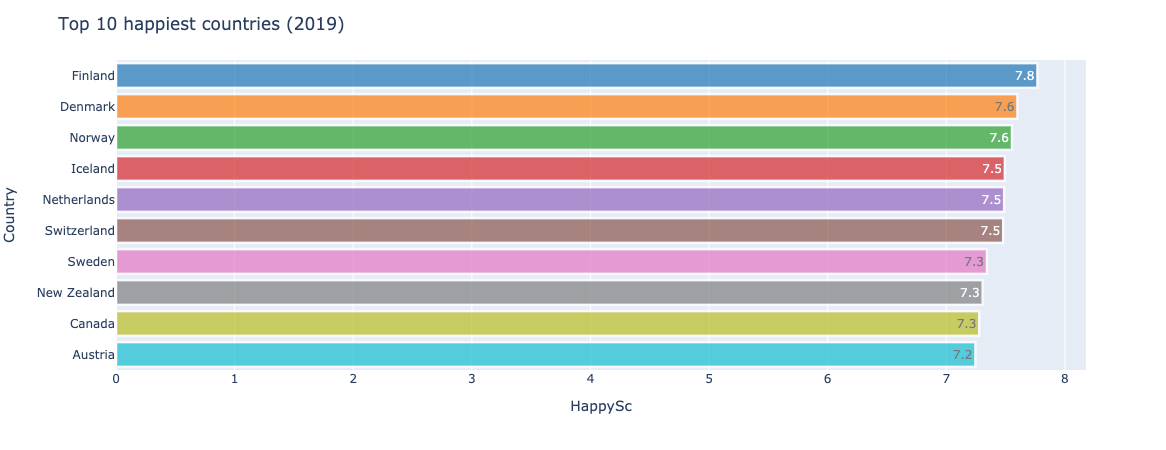

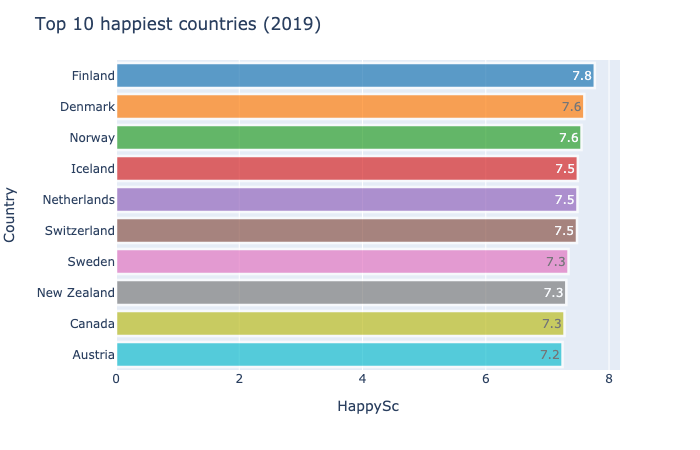

In [11]:
# creating an interactive barplot to show the 10 happiest countries

# defining the Parameters 
most_happy = px.bar(data_frame = happy.nlargest(10,"HappySc"), # input for barplot
             y="Country", # y-axis
             x="HappySc", # x-axis
             orientation='h', # horizontal plot
             color="Country", # show different colors for the countries
             text="HappySc", # interactive Text shows the Happiness-score
             color_discrete_sequence=px.colors.qualitative.D3) # defining the selected color

most_happy.update_traces(texttemplate='%{text:.2s}', # show happiness-score in the bar, rounded to one decimal place
                  marker_line_color='rgb(255,255,255)', 
                  marker_line_width=2.5, # distance between the bars
                  opacity=0.7) # density of the bar-color
most_happy.update_layout(width=800, # size of the plot
                  showlegend=False, # not to double the Country-Names
                  title="Top 10 happiest countries (2019)", # ... and the title 
)
most_happy.show() # interactive plot for notebook
most_happy.show("png") # picture of plot for GitHub

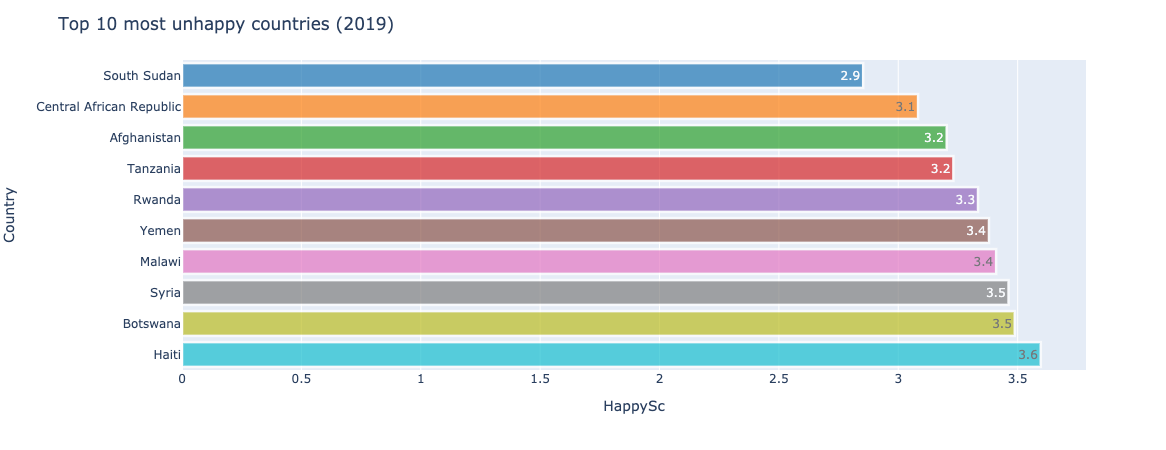

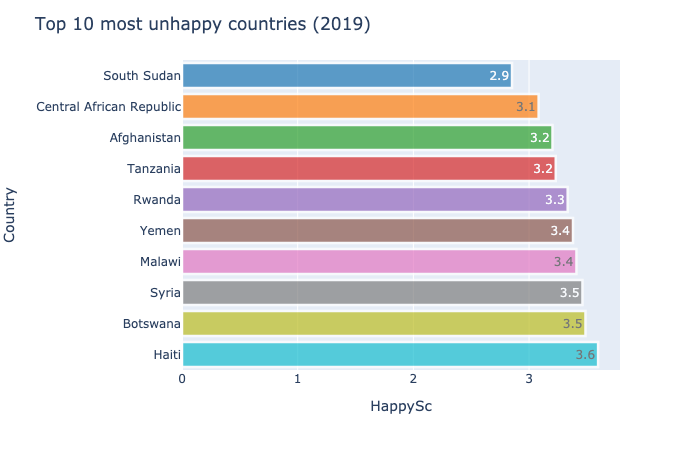

In [12]:
# creating an interactive barplot to show the 10 most unhappy countries, commentation see graphic above
least_happy = px.bar(data_frame = happy.nsmallest(10,"HappySc"),
             y="Country",
             x="HappySc",
             orientation='h',
             color="Country",
             text="HappySc",
             color_discrete_sequence=px.colors.qualitative.D3)

least_happy.update_traces(texttemplate='%{text:.2s}',  
                  marker_line_color='rgb(255,255,255)', 
                  marker_line_width=2.5, 
                  opacity=0.7)
least_happy.update_layout(width=800,
                  showlegend=False,
                  title="Top 10 most unhappy countries (2019)",
)
least_happy.show() # interactive plot for notebook
least_happy.show("png") # picture of plot for GitHub

#### How is the "region" distributed in both Top 10?
##### Top 10 happiest countries

In [13]:
happy.loc[0:9, ["HappyRk", "Country", 'Region']]

HappyRk      Country          Region
0        1      Finland  Western Europe
1        2      Denmark  Western Europe
2        3       Norway  Western Europe
3        4      Iceland  Western Europe
4        5  Netherlands  Western Europe
5        6  Switzerland  Western Europe
6        7       Sweden  Western Europe
7        8  New Zealand         Oceania
8        9       Canada   North America
9       10      Austria  Western Europe

##### Top 10 most unhappy countries

In [14]:
happy.loc[146:, ["HappyRk", "Country", 'Region']]

HappyRk                   Country                         Region
146      147                     Haiti  Latin America & the Caribbean
147      148                  Botswana             Sub-Saharan Africa
148      149                     Syria     Middle East & North Africa
149      150                    Malawi             Sub-Saharan Africa
150      151                     Yemen     Middle East & North Africa
151      152                    Rwanda             Sub-Saharan Africa
152      153                  Tanzania             Sub-Saharan Africa
153      154               Afghanistan                     South Asia
154      155  Central African Republic             Sub-Saharan Africa
155      156               South Sudan             Sub-Saharan Africa

#### The happiest countries are mainly in Western Europe, the least happy in the African region. Is this a coincidence?
#### What does a look at the average happiness-score for each region tell us?

In [15]:
# creating a simple and fast code just to list the means, better view on the graph below
a = happy[['Region', 'HappySc']] #small Frame
a = a.groupby('Region').mean() # groupby the mean (Happy-Score) after Region
print("Mean of happiness-score by region")
a.sort_values('HappySc', ascending=False) # show in order happier to unhappier

Mean of happiness-score by region


HappySc
Region                                 
Oceania                        7.267500
North America                  7.085000
Western Europe                 7.035278
Latin America & the Caribbean  5.954429
East Asia                      5.688833
Eastern Europe                 5.670458
Caucasus & Central Asia        5.280500
Middle East & North Africa     5.237000
South Asia                     4.946938
Sub-Saharan Africa             4.300050

#### There is definitely a significant difference of the happiness-score between regions.
#### Let's look into it a little more

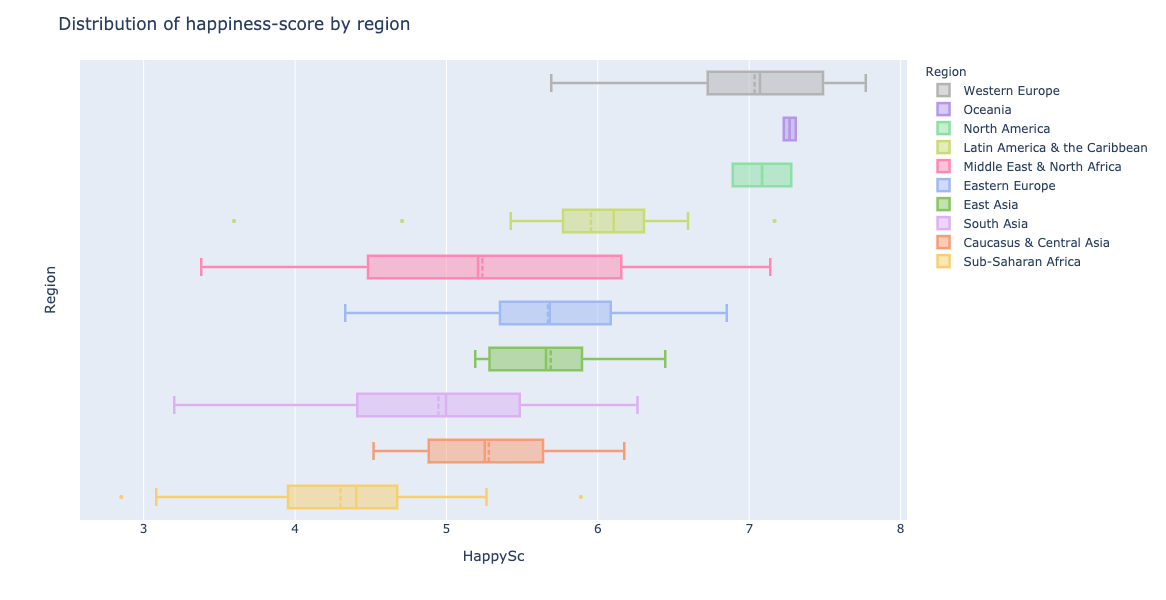

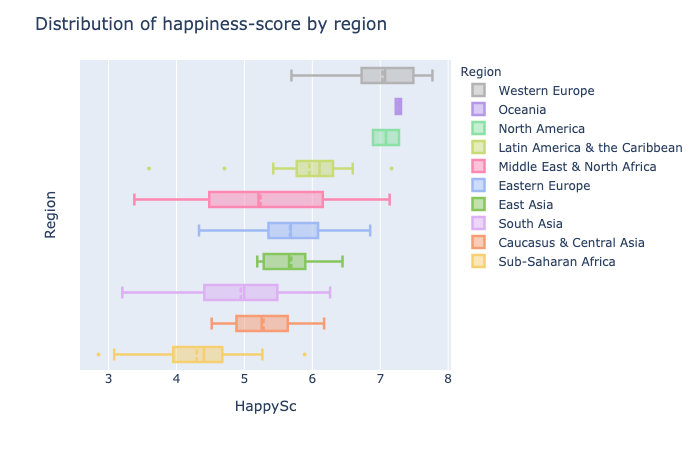

In [16]:
# creating an interactive boxplot with min, max, mean, median and the q1 and q3-quartiles of the happiness-score for every region

fig = px.box(happy, # input for the plot
             x="HappySc",
             y="Region",
             color="Region", # different colors for each region
             color_discrete_sequence=px.colors.qualitative.Pastel_r,) # used colorscale for this plot

# Defining inside of the plot
fig.update_traces(boxmean=True, # represents mean
                  whiskerwidth=0.8, # endline on min and max
                  marker_size=4, # size of the residuals (points)
                  line_width=2.5 # widht of the lines and frames
                 
                  )

# defining height, width, legend and title of the plot
fig.update_layout(height=600,
                  width=800,
                  showlegend=True, # shows the (Region-) legend on the right
                  yaxis= dict(showticklabels = False), # Because of "showlegend" - here: False to not double the labels
                  title="Distribution of happiness-score by region")
iplot(fig) # interactive plot for notebook
fig.show("png") # picture of the plot for GitHub

### The regions of Western Europe, Oceania, and North America are far happier than the rest of the world.
#### The region with the greatest variety of happiness-score is the "Middle East and North Africa" region. Before we take a closer look at this region, let's first look at the global distribution of happiness on a world map. 

### How is the distribution reflected on the world map?

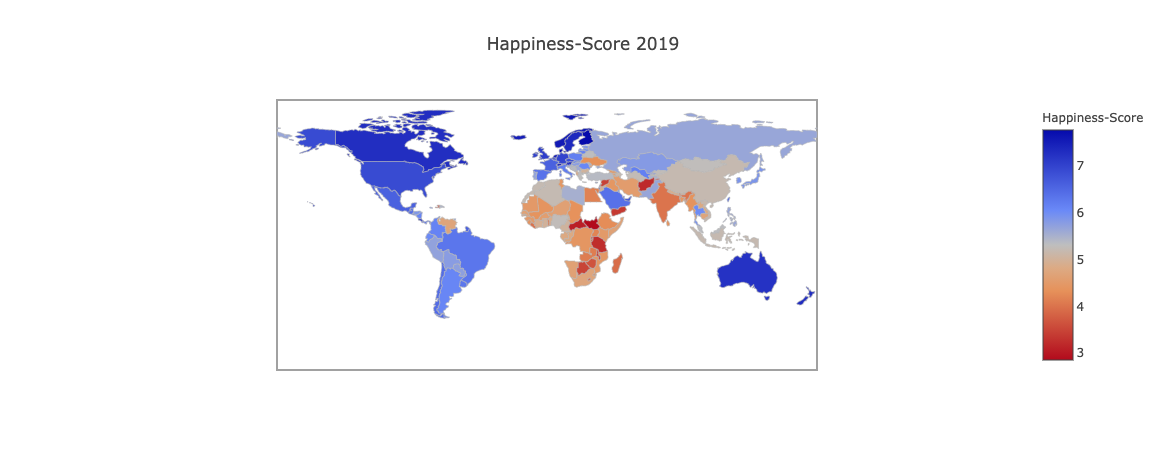

In [17]:
# crerating an interactive geoplot to show the global wheighted distribution of Happiness

import plotly.offline as py # import of the needed module

happyplot = [dict(
    type = 'choropleth', # type of the geoplot
    locations = happy['Country'], 
    locationmode = 'country names', # fitting the Data with the plot presets
    z = happy['HappySc'], # show Happyscore by interaction with the plot
    text = happy['Country'], # show Country-name by interaction with the plot
    colorscale = [[0,"rgb(5, 10, 172)"],[2,"rgb(40, 60, 190)"],[4,"rgb(70, 100, 245)"],\
                [6,"rgb(90, 120, 245)"],[8,"rgb(106, 137, 247)"],[10,"rgb(220, 220, 220)"]], # copied a colorscale whisch I want to use
    autocolorscale = False, # True changes in another color-scheme
    reversescale = True, # False turns the color bar around 
    marker = dict(line = dict(color = 'rgb(180,180,180)',width = 0.5 )), # settings for the plot
    colorbar = dict(autotick=False, tickprefix= '', title='Happiness-Score'), # defining colorbar and its title
)]

# defining title and the projection-type, show black frame around the plot and hide the coastlines (and the poles)
layout = dict(
    title = 'Happiness-Score 2019', # title of the plot
    geo = dict(showframe=True, showcoastlines=False, projection=dict(type='Mercator'))
)

fig = dict(data=happyplot, layout=layout) # establish the given presets
py.iplot( fig, validate=False) # plotting with avoid of validation

![title](img/Worldmap.png)

### A look at the world map clearly shows a significant distribution of happiness in the regions
#### The happiest regions are Western Europe, Oceania and North America
#### South America, Eastern Europe and North Asia are on average neither particularly happy nor unhappy
#### Africa, most of the Middle East and Central and South Asia are mostly below the mean of the Happiness-Score

### Interesting observation on the side: Democratic systems (here: green) are distributed very similarly on the world map.

![title](img/democracy.png)

#### Let us now examine whether there is a reason why the happiness values in the "Middle East and North Africa" region are widely dispersed unlike the other regions.
##### First, I create a data frame for this region (19 countries) and look at the data

In [18]:
# Creating a dataframe only with the countries of the selected region
arab = happy.query('Region == "Middle East & North Africa"')
arab

Country ISO_code                      Region  HappyRk  \
12                    Israel      ISR  Middle East & North Africa       13   
20      United Arab Emirates      ARE  Middle East & North Africa       21   
27              Saudi Arabia      SAU  Middle East & North Africa       28   
28                     Qatar      QAT  Middle East & North Africa       29   
36                   Bahrain      BHR  Middle East & North Africa       37   
50                    Kuwait      KWT  Middle East & North Africa       51   
71                     Libya      LBY  Middle East & North Africa       72   
78                    Turkey      TUR  Middle East & North Africa       79   
87                   Algeria      DZA  Middle East & North Africa       88   
88                   Morocco      MAR  Middle East & North Africa       89   
90                   Lebanon      LBN  Middle East & North Africa       91   
100                   Jordan      JOR  Middle East & North Africa      101   
109  Palestinian Territories      PSE  Middle East & North Africa      110   
116                     Iran      IRN  Middle East & North Africa      117   
123                  Tunisia      TUN  Middle East & North Africa      124   
125                     Iraq      IRQ  Middle East & North Africa      126   
136                    Egypt      EGY  Middle East & North Africa      137   
148                    Syria      SYR  Middle East & North Africa      149   
150                    Yemen      YEM  Middle East & North Africa      151   

     HappySc  GDP_per_capita  Family  LifeExp  Freedom  Generosity  GovTrust  
12     7.139           1.276   1.455    1.029    0.371       0.261     0.082  
20     6.825           1.503   1.310    0.825    0.598       0.262     0.182  
27     6.375           1.403   1.357    0.795    0.439       0.080     0.132  
28     6.374           1.684   1.313    0.871    0.555       0.220     0.167  
36     6.199           1.362   1.368    0.871    0.536       0.255     0.110  
50     6.021           1.500   1.319    0.808    0.493       0.142     0.097  
71     5.525           1.044   1.303    0.673    0.416       0.133     0.152  
78     5.373           1.183   1.360    0.808    0.195       0.083     0.106  
87     5.211           1.002   1.160    0.785    0.086       0.073     0.114  
88     5.208           0.801   0.782    0.782    0.418       0.036     0.076  
90     5.197           0.987   1.224    0.815    0.216       0.166     0.027  
100    4.906           0.837   1.225    0.815    0.383       0.110     0.130  
109    4.696           0.657   1.247    0.672    0.225       0.103     0.066  
116    4.548           1.100   0.842    0.785    0.305       0.270     0.125  
123    4.461           0.921   1.000    0.815    0.167       0.059     0.055  
125    4.437           1.043   0.980    0.574    0.241       0.148     0.089  
136    4.166           0.913   1.039    0.644    0.241       0.076     0.067  
148    3.462           0.619   0.378    0.440    0.013       0.331     0.141  
150    3.380           0.287   1.163    0.463    0.143       0.108     0.077

In [19]:
arab.describe()

HappyRk    HappySc  GDP_per_capita     Family    LifeExp    Freedom  \
count   19.000000  19.000000       19.000000  19.000000  19.000000  19.000000   
mean    84.894737   5.237000        1.059053   1.148684   0.751053   0.317947   
std     44.505798   1.060322        0.347438   0.262718   0.143435   0.166747   
min     13.000000   3.380000        0.287000   0.378000   0.440000   0.013000   
25%     44.000000   4.504500        0.875000   1.019500   0.672500   0.205500   
50%     89.000000   5.208000        1.043000   1.225000   0.795000   0.305000   
75%    120.500000   6.110000        1.319000   1.316000   0.815000   0.428500   
max    151.000000   7.139000        1.684000   1.455000   1.029000   0.598000   

       Generosity   GovTrust  
count   19.000000  19.000000  
mean     0.153474   0.105000  
std      0.086916   0.040251  
min      0.036000   0.027000  
25%      0.081500   0.076500  
50%      0.133000   0.106000  
75%      0.237500   0.131000  
max      0.331000   0.182000

#### With the exception of Israel, all countries are Muslim. Because the happiness factor varies greatly between these countries, religion does not seem to have anything to do with happiness.
#### Let's look at the correlation map for this region

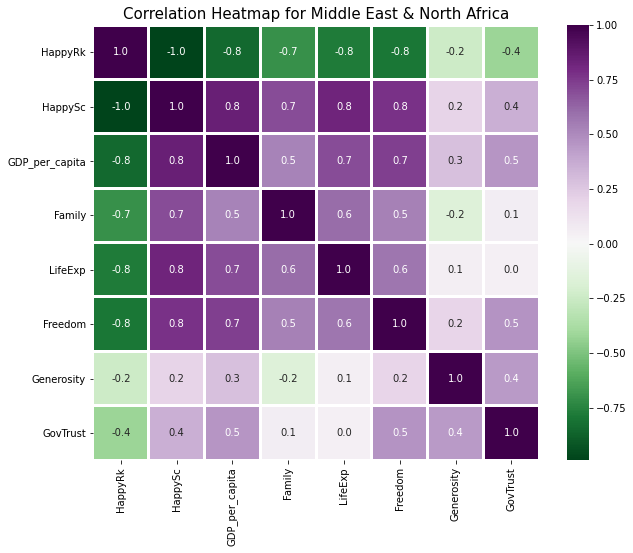

In [20]:
plt.figure(figsize=(10,8)) # Creating size of plot (height, width)
plt.title("Correlation Heatmap for Middle East & North Africa",fontsize=15) #adding title and its fontsize

# creating colored heatmap (cmap), annot = "True" puts the values in, fmt formats this value 
# and the linewidhts define the distance of the coloured clusters
sns.heatmap(data=arab.corr(),cmap="PRGn_r",annot=True, fmt='.1f', linewidths=2)

plt.show()

#### The correlations between the individual features and the happiness-score for this region are almost identical to those for the entire world.
#### Only "freedom" (0.6 raised to 0.8) seems to be more important in this region in order to be happy.
#### Using the four most correlated features and listing only the countries that are above the mean of these characteristics simply gives you a list of the happiness-score-leading countries in that region.
#### There is therefore no difference in the assessment by region

In [21]:
arab[(arab['Family'] >= 1.148) & (arab['GDP_per_capita'] >= 1.059) & (arab['LifeExp'] >= 0.751) & (arab['Freedom'] >= 0.317)]

Country ISO_code                      Region  HappyRk  \
12                Israel      ISR  Middle East & North Africa       13   
20  United Arab Emirates      ARE  Middle East & North Africa       21   
27          Saudi Arabia      SAU  Middle East & North Africa       28   
28                 Qatar      QAT  Middle East & North Africa       29   
36               Bahrain      BHR  Middle East & North Africa       37   
50                Kuwait      KWT  Middle East & North Africa       51   

    HappySc  GDP_per_capita  Family  LifeExp  Freedom  Generosity  GovTrust  
12    7.139           1.276   1.455    1.029    0.371       0.261     0.082  
20    6.825           1.503   1.310    0.825    0.598       0.262     0.182  
27    6.375           1.403   1.357    0.795    0.439       0.080     0.132  
28    6.374           1.684   1.313    0.871    0.555       0.220     0.167  
36    6.199           1.362   1.368    0.871    0.536       0.255     0.110  
50    6.021           1.500   1.319    0.808    0.493       0.142     0.097

#### "Region" is about neighborhood. So let's compare two direct neighbors: Yemen and Saudi Arabia

In [22]:
happy.loc[[27, 150]]

Country ISO_code                      Region  HappyRk  HappySc  \
27   Saudi Arabia      SAU  Middle East & North Africa       28    6.375   
150         Yemen      YEM  Middle East & North Africa      151    3.380   

     GDP_per_capita  Family  LifeExp  Freedom  Generosity  GovTrust  
27            1.403   1.357    0.795    0.439       0.080     0.132  
150           0.287   1.163    0.463    0.143       0.108     0.077

#### Two direct neighbors. Saudi Arabia's GDP per capita is almost five times that of Yemen. The values for health-life expectancy and freedom are also significantly different. No wonder Saudi Arabia is three steps higher on the Cantril ladder. With only 156 countries, these two countries are 123 places apart in the global happiness ranking.
#### The "region" is the same but obviously has no effect on each other.

## Conclusion:

#### 1. There is a different distribution of happiness between regions
####  - The happiest regions are Western Europe, Oceania and North America
####  - South America, Eastern Europe, North and East Asia are on average neither particularly happy nor unhappy
####  - Africa, most of the Middle East, South and Central Asia are the most unhappy regions
#### 2. Nevertheless "region" is not a feature that can explain the happiness-score

# 3. How well is the happiness-score predictable by its features?

### First I try different regression-models with all the given features to find out which is the best.
#### I take two linear models (Linear Regression and Bayesian Ridge), a Decision-Tree and, as an ensemble-method, a Random Forest-Regression

In [23]:
# Importing the regression-modules for Linear-, Tree- and Ensemble-Regression

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Importing train_test_split-module
from sklearn.model_selection import train_test_split # for data validation

# Metrics and Grid Search
from sklearn import model_selection, metrics

In [24]:
# Creating the table with all given features
data_model = happy.groupby('Country')['HappySc', 'GDP_per_capita',
       'Family', 'LifeExp',
       'Freedom', 'Generosity',
       'GovTrust'].mean().reset_index()

# Determining the dependent and independent variables
y = data_model['HappySc']
X = data_model[['GDP_per_capita',
       'Family', 'LifeExp',
       'Freedom', 'Generosity',
       'GovTrust']]

# Splitting the data to avoid under/overfitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

In [25]:
# Creating a predefined function to test the models
a = [] # A list for help printing the results
def modelfit(model): #function as a basic for all predictive models
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = metrics.mean_absolute_error(y_test, preds) #The metric I use is the mean absolute error for all models
    a.append(round(mae,3))

# Running every model

# Linear Regression
lm = LinearRegression(n_jobs = -1)
modelfit(lm)
    
# Bayesian Linear Model
br = BayesianRidge(n_iter=1000, tol = 0.5)
modelfit(br)

# Decision Tree Regression
dt = DecisionTreeRegressor()
modelfit(dt)

# Ensemble Method: Random Forest
rf = RandomForestRegressor(n_jobs = -1)
modelfit(rf)

#print-function to see the results together
print('Linear Regression has a MAE of:    ' + str(a[0]))
print('Bayesian Linear Model has a MAE of:' + str(a[1]))
print('The Decision Tree has a MAE of:    ' + str(a[2]))
print('Random Forest has a MAE of:        ' + str(a[3]))

Linear Regression has a MAE of:    0.403
Bayesian Linear Model has a MAE of:0.406
The Decision Tree has a MAE of:    0.485
Random Forest has a MAE of:        0.383


### The Random Forest method gives the best result when all features of the original data set are used.
### After we have determined that there is a significant distribution by region, we will try to optimize the forecast with it.

#### First I create a new column "RgCode" with a numeric code for the regions

In [26]:
# Creating a column with numeric code for the region
happy.Region = pd.Categorical(happy.Region) # First, I change the type of the column into "Categorial"
happy['RgCode'] = happy.Region.cat.codes # Now I create a new column "RgCode" and add it to my dataset
happy.head()

Country ISO_code          Region  HappyRk  HappySc  GDP_per_capita  \
0      Finland      FIN  Western Europe        1    7.769           1.340   
1      Denmark      DNK  Western Europe        2    7.600           1.383   
2       Norway      NOR  Western Europe        3    7.554           1.488   
3      Iceland      ISL  Western Europe        4    7.494           1.380   
4  Netherlands      NLD  Western Europe        5    7.488           1.396   

   Family  LifeExp  Freedom  Generosity  GovTrust  RgCode  
0   1.587    0.986    0.596       0.153     0.393       9  
1   1.573    0.996    0.592       0.252     0.410       9  
2   1.582    1.028    0.603       0.271     0.341       9  
3   1.624    1.026    0.591       0.354     0.118       9  
4   1.522    0.999    0.557       0.322     0.298       9

In [27]:
# Looking for the dtype
happy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156 entries, 0 to 155
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Country         156 non-null    object  
 1   ISO_code        156 non-null    object  
 2   Region          156 non-null    category
 3   HappyRk         156 non-null    int64   
 4   HappySc         156 non-null    float64 
 5   GDP_per_capita  156 non-null    float64 
 6   Family          156 non-null    float64 
 7   LifeExp         156 non-null    float64 
 8   Freedom         156 non-null    float64 
 9   Generosity      156 non-null    float64 
 10  GovTrust        156 non-null    float64 
 11  RgCode          156 non-null    int8    
dtypes: category(1), float64(7), int64(1), int8(1), object(2)
memory usage: 19.1+ KB


In [28]:
# Changing the dtype of my "Region"-column back from categorical to object
happy["Region"] = happy.Region.astype(str)

#### Now we take the region into consideration to see if we can lower the mean absolute error of our prediction at the best model

In [29]:
# Creating the new table with 'RgeCode' inside
data_model = happy.groupby('Country')['HappySc', 'GDP_per_capita',
       'Family', 'LifeExp','Freedom', 'Generosity', 'RgCode',
       'GovTrust'].mean().reset_index()

# Creating the dependent and independent variables
y = data_model['HappySc']
X = data_model[['GDP_per_capita','Family', 'LifeExp', 'Generosity', 'RgCode',
       'Freedom', 'GovTrust']]

# Splitting the data to avoid under/overfitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

In [30]:
# Running Random Forest with added feature "Region"
rfr = RandomForestRegressor(n_jobs = -1, n_estimators=1000) # Adding also estimaters as a hyperparameter
modelfit(rfr)
print('Random Forest without "Region" has a MAE of:     ' + str(a[3]) + ' and')
print('Random Forest with "Region" has a MAE of:        ' + str(a[4]))

Random Forest without "Region" has a MAE of:     0.383 and
Random Forest with "Region" has a MAE of:        0.356


#### Taking the additional feature into account reduces the mean absolute error for a better result.
#### Let's take a look at the feature importance of this final model

In [31]:
# import modules for measuring feature-importance for my best model
from sklearn.metrics import r2_score # using R-Squared as metrics
#from sklearn.metrics import mean_absolute_error
from rfpimp import permutation_importances 

#def mae(rfr, X_train, y_train):
#    return mean_absolute_error(y_train, rfr.predict(X_train))
#importance = permutation_importances(rfr, X_train, y_train, mae)
def r2(rfr, X_train, y_train):
    return r2_score(y_train, rfr.predict(X_train))
importance = permutation_importances(rfr, X_train, y_train, r2)

In [32]:
print("Feature importance of the best model")
print("")
print(importance)

Feature importance of the best model

                Importance
Feature                   
GDP_per_capita    0.317003
Family            0.302612
LifeExp           0.131239
Freedom           0.124897
GovTrust          0.026104
Generosity        0.021337
RgCode            0.019733


## Conclusion

#### The importance of the features was also confirmed in the models. The accuracy of the prediction is not that bad. 
#### Although the feature importance for "Region" is given as low, several runs of the models have shown that taking in this additional feature achieves better prediction-results. 
#### NOTE! "Region" in itself has no significance for happiness like the other features. It can only be used to improve a prediction-model in this dataset and not as an explaining feature for happiness.

# SUMMARY and personal thoughts

## Happiness is subjective well-being
### The question, what actually influences our general well-being, is mainly answered with 
#### Money
#### Health and
#### Family and friends

#### Imagine you are happy. Ask yourself what could be making you unhappy. What if you don't know where to sleep tonight? How to get food for your family? Do my children get a chance for a good life? And no matter what problems you are facing, acute pain or a serious illness will cover them all.
#### Is money really the most important thing for our happiness? Most problems can be solved with money, that is a fact. Even if the gross domestic product (GDP) only indirectly said something about personal prosperity, it is clearly the most important factor as it influences all other factors. With money you can go to doctors and hospitals and get cured. With money you give your family a home, food and social security. Money gives you the freedom to develop your life the way you want it. And belief in the sincerity of your government? Who cares if you're fine? It's not the money, it's the opportunities that it offers. If you don't have it, you know what I'm talking about.
#### Without health, everything is nothing. Why is it not rated higher. I suspect that we have to do with money or money problems every day, but only with health if it is not good. We only think about health in everyday life when we feel sick. Otherwise, it seems normal to us.
#### Family and friends are our everyday life. Of course that's important for my well-being.
#### Freedom to make life choices, i. e. self-realization, becomes important when the aforementioned points are satisfied.
#### The perception of corruption seems mostly interesting if it has a negative impact on your life.
#### Generosity has nearly no impact. In my opinion, this point should only be included when comparing the happiest countries.

#### Even if globally significant regional differences are visible, the happiness score is not influenced by this. Luck is a matter of each single country

### Let's close the notebook with the first lines of the poem "The Choice Is Mine" by Abimbola T. Alabi

## Life may not let me choose my lot
## But whether I'd be happy or not...
## That is my choice.